# Aiyagari model

This code seems to work well. Please tell me if you find something wrong.

In [1]:
using Distributions
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("tauchen.jl")

tauchen (generic function with 2 methods)

In [3]:
function Aggregate_Labor(zgrid,Π)
    const nz = size(zgrid,1)
    probst =    ones(nz)./nz
    probst1 = similar(probst)
    err = 1.0
    const tol = 1e-8
    Trans = transpose(Π)

    while err > tol
        probst1 = Trans*probst
        err=maximum(abs.(probst1-probst))
        probst = copy(probst1)  
    end

    L = dot(probst,zgrid)
    return L
end

Aggregate_Labor (generic function with 1 method)

In [4]:
type Model
    β::Float64
    μ::Float64
    b::Float64
    α::Float64
    δ::Float64
    zgrid::Array{Float64,1}
    Π::Array{Float64,2}
    L::Float64
end

In [5]:
function main(m::Model)
    #primitive parameter
    const β = m.β#0.96 #subjective discount factor
    const μ = m.μ # relative risk aversion
    const b = m.b#3.0 # debt limit
    const α = m.α#0.36 # capital share
    const δ = m.δ#0.08 # delta

    #discretize indivisual shock
    zgrid = m.zgrid
    Π　= m.Π
    const nz = size(zgrid,1)

    #aggregate labor
    const L = m.L

    #initialization
    const na = 100
    agrid::Array{Float64,1} = zeros(na)
    util = zeros(na,na,nz)
    v0 = ones(na,nz)
    EV = ones(v0)
    Tv = zeros(na,nz)
    a_index::Array{Int64,2} = zeros(na,nz)
    dist0 = ones(na,nz)./(na*nz)
    dist1 = zeros(na,nz)
    
    #iteration setting
    const maxiter = 1000
    const tol = 1e-5
    const neg::Float64 = -1e10
    it =0
    err_k = 10.0
    
    # itinial guess
    K0 = 5.0
    
    #Outside Loop
    while err_k > 1e-4  # caution! Model cannot converge due to  more strict tolerance.
        
        
        # compute factor price
        r0 = α*(K0^(α-1.0))*(L^(1.0-α)) -δ
        w0 = (1.0-α)*(K0^α)*(L^(-α))
        
        # create asset grid
        if r0 > 0.0
            amin  = min(b,(w0*zgrid[1])/r0)
        else
            amin = b
        end
        
        const amax = 16.0 
        agrid = linspace(-amin,amax,na)

        # create utility matrix
        for i in 1:na
            for j in 1:na
                for z in 1:nz
                    c = w0*zgrid[z] +(1.0+r0)*agrid[i] - agrid[j]
                    if c >= 0.0
                        @inbounds util[i,j,z] = (c^(1.0-μ))/(1.0-μ)
                    else
                        @inbounds util[i,j,z] = neg
                    end
                end
            end
        end
        
        # solve indivisual problem
        for VFI_it in 1: maxiter
            EV = v0*Π'
            for z in 1:nz
                gridnext::Int64 = 1
                for i in 1:na
                    vmin = neg
                    for j in gridnext:na # monotonicity
                        @inbounds  v = util[i,j,z] + β*EV[j,z]
                        if v > vmin
                            vmin = copy(v)
                            gridnext = j
                        else
                            break #concavicity
                        end
                    end
                    @inbounds Tv[i,z] = copy(vmin)
                    @inbounds a_index[i,z] = gridnext
                end
            end
            
            err = maximum(abs.(Tv-v0))
            v0 = copy(Tv)
            if err < tol
                break
            end
        end   
        #end of indivisual problem
        
        # compute distribution
        for dist_it in 1:maxiter# calculate the invariant distribution
            for i in 1 : na
                for j in 1 : nz
                    @inbounds h = a_index[i,j]
                    for zz in 1 : nz
                        @inbounds dist1[h,zz] += Π[zz,j]*dist0[i,j]
                    end                    
                end
            end
            err = maximum(abs.(dist1-dist0))
            dist0 = copy(dist1)  # invariant distribution
            dist1 = zeros(na,nz)
            if err < tol
                break
            end
        end
        
        # aggregation
        K1 = 0.0
        for j in 1:na
            @inbounds @views K1 += agrid[j]* sum(dist0[j,:])
        end
        
        # update aggregate capital
        K0 = 0.98*K0 +0.02*K1
        
        # update error 
        err_k = abs(K0-K1)
        
        it +=1
        if it >= maxiter
            println("the model cannot converge in $maxiter times iteration")
            break
        end
        #println("iteration: $it, error =$err_k")
    end
    return agrid,K0, L, dist0
end

main (generic function with 1 method)

In [6]:
β=0.96
μ=3.0
b=3.0
α=0.36
δ=0.08
σ=0.4
ρ=0.2
nz = 7
zgrid,Π = tauchen(nz,ρ,σ)
L = Aggregate_Labor(zgrid,Π)
model = Model(β,μ,b,α,δ,zgrid,Π,L)

Model(0.96, 3.0, 3.0, 0.36, 0.08, [0.293833, 0.441977, 0.664814, 1.0, 1.50418, 2.26256, 3.4033], [0.0262397 0.152923 … 0.0152661 0.000778287; 0.0160444 0.114742 … 0.0247006 0.00153919; … ; 0.00153919 0.0247006 … 0.114742 0.0160444; 0.000778287 0.0152661 … 0.152923 0.0262397], 1.0943782080784177)

In [7]:
agrid ,K, L,dist0 = main(model)

([-3.0, -2.80808, -2.61616, -2.42424, -2.23232, -2.0404, -1.84848, -1.65657, -1.46465, -1.27273  …  14.2727, 14.4646, 14.6566, 14.8485, 15.0404, 15.2323, 15.4242, 15.6162, 15.8081, 16.0], 6.097413499210498, 1.0943782080784177, [3.70445e-5 2.78389e-5 … 7.08085e-6 4.73647e-6; 0.000136015 0.000112916 … 4.34328e-5 3.2233e-5; … ; 0.000146954 0.000175226 … 0.000296006 0.000327054; 0.000114021 0.000163636 … 0.000547349 0.000703538])

In [8]:
r = α*(K^(α-1.0))*(L^(1.0-α)) -δ
println("$r")
w0 = (1.0-α)*(K^α)*(L^(-α));
println(w0)

0.03991581003617187
1.1877693932880875


In [9]:
@time main(model);

  0.428612 seconds (15.77 k allocations: 66.374 MiB, 6.21% gc time)


Asset Distribution looks like that of LS. Here is the plot.


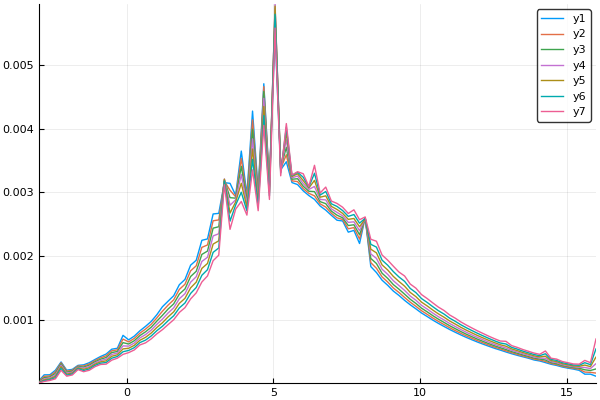

In [10]:
plot(agrid,dist0)

In [ ]:
@profile main(model);
Profile.print()